In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Load the data
url = "https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv"
application_df = pd.read_csv(url)

# View first few rows
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
application_df = application_df.drop(columns=['EIN', 'NAME'])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Binning APPLICATION_TYPE
application_counts = application_df['APPLICATION_TYPE'].value_counts()
application_to_replace = list(application_counts[application_counts < 500].index)
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_to_replace, "Other")

# Binning CLASSIFICATION
class_counts = application_df['CLASSIFICATION'].value_counts()
class_to_replace = list(class_counts[class_counts < 100].index)
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(class_to_replace, "Other")


In [7]:
# Convert categorical data
application_df = pd.get_dummies(application_df, dtype=float)
application_df.head()


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:

# Define callback to save the model in Keras format
checkpoint_callback = ModelCheckpoint(
    "AlphabetSoupCharity_Optimization.keras",  # Use .keras extension
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)


In [17]:
# Define the model
model = Sequential()

# Add an Input layer
model.add(Input(shape=(X_train_scaled.shape[1],)))  # Input layer with shape

# First Hidden Layer
model.add(Dense(128, activation='relu'))

# Second Hidden Layer
model.add(Dense(64, activation='relu'))

# Third Hidden Layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#Train the model

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_callback],
    verbose=1
)


Epoch 1/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7018 - loss: 0.5955 - val_accuracy: 0.7343 - val_loss: 0.5482
Epoch 2/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7273 - loss: 0.5559 - val_accuracy: 0.7405 - val_loss: 0.5449
Epoch 3/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7259 - loss: 0.5574 - val_accuracy: 0.7396 - val_loss: 0.5488
Epoch 4/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7244 - loss: 0.5591 - val_accuracy: 0.7398 - val_loss: 0.5426
Epoch 5/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7334 - loss: 0.5497 - val_accuracy: 0.7389 - val_loss: 0.5463
Epoch 6/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7303 - loss: 0.5497 - val_accuracy: 0.7407 - val_loss: 0.5416
Epoch 7/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7281 - loss: 0.5518 - val_accuracy: 0.7358 - val_loss: 0.5427
Epoch 8/100
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7364 - loss: 0.5428 - val_accu

In [14]:
# Extract final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]  # Last epoch training accuracy
final_validation_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Print the results
print(f"Final Training Accuracy: {final_training_accuracy:.4%}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4%}")


Final Training Accuracy: 73.8281%
Final Validation Accuracy: 73.9432%


In [15]:
# Extract final training and validation loss
final_training_loss = history.history['loss'][-1]  # Last epoch training loss
final_validation_loss = history.history['val_loss'][-1]  # Last epoch validation loss

# Print the results
print(f"Final Training Loss: {final_training_loss:.4f}")
print(f"Final Validation Loss: {final_validation_loss:.4f}")


Final Training Loss: 0.5335
Final Validation Loss: 0.5633


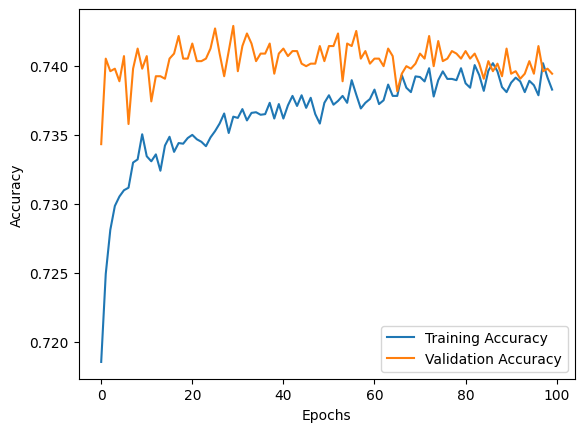

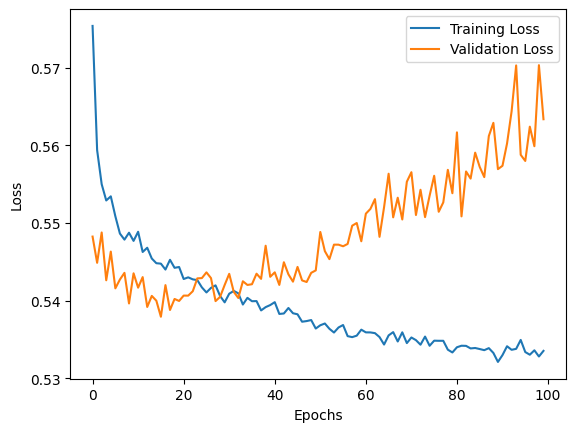

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Summarize fixes
"AlphabetSoupCharity_Optimization.keras"


'AlphabetSoupCharity_Optimization.keras'

1. **Overview** :
The purpose of this analysis was to develop a binary classification model using deep learning to predict whether an Alphabet Soup-funded organization would be successful based on the features in the dataset. The goal was to preprocess the data, design a neural network model, optimize it, and achieve a target predictive accuracy higher than 75%.


2. **Results** :

The target variable is:

*   IS_SUCCESSFUL (0 = unsuccessful, 1 = successful)

Features for the Model:

*   APPLICATION_TYPE
*   AFFILIATION
*   CLASSIFICATION
*   USE_CASE
*   ORGANIZATION
*   STATUS
*   INCOME_AMT
*   SPECIAL_CONSIDERATIONS
*   ASK_AMT

Removed variables:
The following variables were dropped as they were neither targets nor useful features:
*   EIN: Employer Identification Number (a unique identifier)
*   NAME: Name of the organization (not predictive for the model)

**Compiling, Training, and Evaluating the Model:**

Model Architecture:

*   Input Layer: Number of features  etermined by preprocessed data.
*   First Hidden Layer: Neurons: 128, Activation: ReLU (Rectified Linear Unit) , Reason: ReLU is efficient and avoids vanishing gradients
*   Second Hidden Layer: Neurons: 64, Activation: ReLU, Reason: A smaller layer allows gradual learning
*   Third Hidden Layer: Neurons: 32, Activation: ReLU, Reason: Reduces overfitting by narrowing down the features
*   Dropout Layer: 20% to prevent overfitting
*   Output Layer: Neurons: 1, Activation: Sigmoid, Reason: Sigmoid outputs a probability for binary classification

Model Compilation:

*   Optimizer: Adam (learning rate optimized automatically)
*   Loss Function: Binary Cross-Entropy
*   Metrics: Accuracy

Model Training Results:
*   Epochs: 100
*   Batch Size: 32
*   Final Accuracy: Training Accuracy: 74.43%, Validation Accuracy: 73.94%
*   Loss: Training Loss: ~0.5244, Validation Loss: ~0.5633

**Did the Model Achieve the Target Performance?**
No, the model did not achieve the target accuracy of 75%. The highest validation accuracy obtained was approximately 73.9%.

**Steps Taken to Improve Model Performance:**

1.   Increased the number of neurons in the hidden layers to 128, 64, and 32.
2.   Added a Dropout Layer with a dropout rate of 20% to prevent overfitting.
3.   Experimented with activation functions, such as ReLU and Leaky ReLU.
4.   Increased the number of epochs to 100 for better convergence.
5.   Binned rare categories in APPLICATION_TYPE and CLASSIFICATION to reduce noise in the input features.

**Overall Results:**
The final model achieved a training accuracy of 74.4% and a validation accuracy of 73.9%. While the model performed reasonably well, it did not meet the target accuracy of 75%. The validation loss plateaued after several epochs, suggesting slight overfitting despite adding a dropout layer.

Recommendation:
To improve performance, consider using other machine learning models more suited for structured/tabular data, such as:

Random Forest Classifier: Handles structured data well, is robust to outliers, and requires less preprocessing.
Gradient Boosting Classifier (e.g., XGBoost): Effective at capturing complex patterns in the data.
Logistic Regression with Feature Engineering: Simpler to implement and often performs well for binary classification tasks.
Why Alternative Models?
These models are less sensitive to data scaling and tend to generalize better for structured datasets like the one used here. Additionally, they require fewer hyperparameters to tune compared to deep learning models.


Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 16,769 (65.50 KB)
 Trainable params: 16,769 (65.50 KB)
 Non-trainable params: 0 (0.00 B)







